# Chapter 4: Dynamic Programming

### Exercise 4.1

Q: In Example 4.1, if $\pi$ is the equiprobable random policy, what is $q_\pi(11, \texttt{down})$? What is $q_\pi(7, \texttt{down})$?

A: Example 4.1 describes a 4-by-4 gridworld where the top-left and bottom-right cells are terminal states. Each transition has reward -1 (including invalid actions) and there is no discounting. The (non-terminal) states are numbered left-to-right, then top-to-bottom, starting from 1 for state $(0, 1)$. Since there is no discounting, the (absolute) value of any state corresponds to the expected number of steps it will take to reach a terminal state from that state under the current policy.

Let us start by specifying this gridworld as code and deriving, using iterative policy evaluation, the state value function $v_\pi$ for this policy:

In [1]:
from numpy.testing import assert_almost_equal
import numpy as np
from dp import GridWorld
from dp.solve import iterative_policy_evaluation, StateValueFunction

# Gridworld specified in Example 4.1 of Sutton, Barto (2018)
gridworld_4_1 = GridWorld(
    size=4,
    terminal_states=[(0, 0), (3, 3)],
    default_move_reward=-1.0,
    invalid_action_reward = -1.0,
)

# Evaluate equiprobably random policy
v = StateValueFunction(gridworld_4_1)
def pi(state: tuple[int, int]) -> list[tuple[str, float]]:
    return [(a, 0.25) for a in gridworld_4_1.actions(state)]
iterative_policy_evaluation(v, pi, 1.0)

# Check against the result in the textbook
desired_v = np.array([
    [0.0, -14.0, -20.0, -22.0],
    [-14.0, -18.0, -20.0, -20.0],
    [-20.0, -20.0, -18.0, -14.0],
    [-22.0, -20.0, -14.0, 0.0]
]).ravel()
assert_almost_equal(
    actual=list(v.to_dict().values()),
    desired=desired_v,
    decimal=2,
)

Once we know $v_\pi$, we can compute action values $q_\pi(s, a)$ using the relationship:

$$q_\pi(s, a) = \mathbb{E}_\pi\left[R_{t+1} + \gamma\,v_\pi(S_{t+1}) \mid S_t=s, A_t=a\right].$$

This means, by manual computation (and with $\gamma = 1$):

$$
\begin{align}
q_\pi(11, \texttt{down}) &= -1\\
q_\pi(7, \texttt{down}) &= -15.\\
\end{align}
$$

We can check these results against numerically computing these action values:

In [2]:
assert_almost_equal(
    actual=v.backup_action_value(gridworld_4_1.i2s(11), "s", gamma=1.0),
    desired=-1.0,
    decimal=2,
)
assert_almost_equal(
    actual=v.backup_action_value(gridworld_4_1.i2s(7), "s", gamma=1.0),
    desired=-15.0,
    decimal=2,
)

### Exercise 4.2

Q: In example 4.1, suppose a new state 15 is added to the gridworld just below state 13, and its actions, $\texttt{left}$, $\texttt{up}$, $\texttt{right}$, and $\texttt{down}$, take the agent to states 12, 13, 14, and 15, respectively. Assume that the transitions *from* the original states are unchanged. What, then, is $v_\pi(15)$ for the equiprobable random policy? Now suppose the dynamics of state 13 are also changed, such that action $\texttt{down}$ from state 13 takes the agent to the new state 15. What is $v_\pi(15)$ for the equiprobable random policy in this case?

A: For the first part of the question, we assume transitions from the original states are unchanged. This means that state 15 is not reachable from any of the original states and therefore has no impact on the original states' values. Since

$$v_\pi(15) = -1 + \tfrac{v_\pi(12) + v_\pi(13) + v_\pi(14) + v_\pi(15)}{4},$$

we can rearrange and insert the original state values for states 12, 13 and 14 to find

$$v_\pi(15) = \frac{4}{3} \, \left(-1 + \tfrac{-22 -20 -14}{4}\right) = -20.$$

In the second part of the question, we suppose that going down from state 13 moves the agent to state 15 and are against asked for the value of state 15. We can tackle this by performing iterative policy evaluation, starting from $v_\pi$ as given in the first part of the question. We begin by updating the value of $v_\pi(13)$ but immediately notice that this won't change since (in the first part of the question) $v_\pi(15) = v_\pi(13)$. Therefore we see that none of the other $v_\pi(s)$ will need updating either, i.e. we have already converged. In other words, introducing this transition makes no difference to $v_\pi(15)$ for the equiprobably random policy: it is still -20.

Let's check these answers against a numerical solution. First let's define a `FiniteMDP` class to represent the modified gridworld problem in this exercise. It encapsulates a standard `GridWorld` but augments it to include custom states and transitions, plus uses the state numbering scheme
provided in the exercise:

In [3]:
from itertools import chain
from dp import FiniteMDP

class ModifiedGW(FiniteMDP):
    """Gridworld with added states and transitions,
    as per exercise 4.2 of Sutton, Barto (2018)."""
    
    def __init__(
        self, custom_states_and_transitions):
        self._inner_gw = GridWorld(
            4,
            terminal_states=((0, 0), (3, 3)),
            default_move_reward=-1.0,
            invalid_action_reward=-1.0,
        )
        self.custom_states_and_transitions = custom_states_and_transitions
    
    def mgw2gw_state(self, mgw_state):
        """Translates states (1 to 15) in the exercise to original
        GridWorld states (tuples of ints), where possible. For custom
        states not in the original gridworld, returns None."""
        if mgw_state in self.custom_states_and_transitions.keys():
            return None
        else:
            return self._inner_gw.i2s(mgw_state)
    
    def gw2mgw_state(self, gw_state):
        """Translates original GridWorld states (tuples of ints) to
        the states numbered as per the exercise. Note, 0 represents
        both the terminal states."""
        if gw_state in self._inner_gw.terminal_states:
            return 0
        else:
            return self._inner_gw.s2i(gw_state)
    
    @property
    def states(self):
        return sorted(
            set(range(0, 15)) | self.custom_states_and_transitions.keys()
        )
    
    @property
    def actions(self, state):
        return ("n", "e", "w", "s")
    
    def next_states_and_rewards(self, state: int, action: str):
        if state in self.custom_states_and_transitions.keys():
            next_state = self.custom_states_and_transitions[state][action]
            reward = -1
        else:
            (nss, ps), reward = self._inner_gw.next_states_and_rewards(
                self.mgw2gw_state(state), action
            )
            assert len(nss) == 1
            assert ps[0] == 1.0
            next_state = self.gw2mgw_state(nss[0])
        return ((next_state,), (1.0,),), reward

Now we answer the first part of the question, numerically, by adding a custom state 15, but keeping all other state transitions as they were before.
We then check that an equiprobably random policy yields exactly the same $v_\pi$ as the original problem for original states, as well as a value
of -20 for state 15:

In [4]:
# Set up modified gridworld and run iterative policy evaluation
v_modified_1 = StateValueFunction(
    ModifiedGW(
        {15: {"w": 12, "n": 13, "e": 14, "s": 15}}
    )
)
iterative_policy_evaluation(v_modified_1, pi, gamma=1.0)

# Check if state values are as expected
for s in range(0, 14):
    assert_almost_equal(v_modified_1(s), desired_v[s], decimal=2)
assert_almost_equal(v_modified_1(15), -20.0, decimal=2)

Now we do the same thing for the second part of the question, this time adding custom transitions to state 13 as well as a new state 15. Again we should find the same state value function:

In [5]:
v_modified_2 = StateValueFunction(
    ModifiedGW(
        {
            13: {"w": 12, "n": 9, "e": 14, "s": 15},
            15: {"w": 12, "n": 13, "e": 14, "s": 15},
        },
    )
)
iterative_policy_evaluation(v_modified_2, pi, gamma=1.0)

for s in range(0, 16):
    assert_almost_equal(v_modified_2(s), v_modified_1(s), decimal=2)

### Exercise 4.3

Q: What are the equations analogous to (4.3), (4.4), and (4.5) for the action-value function $q_\pi$ and its successive approximation by a sequence of functions $q_0$, $q_1$, $q_2$, ...?

A: The equations referenced in the question develop the iterative policy evaluation algorithm for approximating the state-value function $v_\pi$. To do the same for the action-value function $q_\pi$, we begin with the Bellman equation for the action-value function:

$$
\begin{align}
q_\pi(s, a) &\doteq \mathbb{E}_\pi \left[ R_{t+1} + \gamma \, q_\pi(S_{t+1}, A_{t+1}) \mid S_t=s, A_t=a\right] \\
&= \sum_{s' \in \mathcal{S}} \sum_{a' \in \mathcal{A}} \pi(a' | s') \, p(s' | s, a) \left[r(s, a, s') + \gamma\,q_\pi(s', a') \right]
\end{align}
$$

This equation is satisfied by a fixed point of the following iteration, leading directly to a iterative policy evaluation algorithm that can be applied directly to action-values:

$$
q_{i+1}(s, a) \doteq \sum_{s' \in \mathcal{S}} \sum_{a' \in \mathcal{A}} \pi(a' | s') \, p(s' | s, a) \left[r(s, a, s') + \gamma\,q_i(s', a') \right]
$$

### Exercise 4.4

Q: The policy iteration algorithm on page 80 has a subtle bug in that it may never terminate if the policy continually switches between two or more policies that are equally good. This is ok for pedagogy, but not for actual use. Modify the pseudocode so that convergence is guaranteed.

A: The scenario described in the question can occur if there are states where two or more actions have the same action value. If different such actions can be selected for different iterations then *policy-stable* can end up remaining false even though the algorithm has actually converged. To fix this, we can update the *if* condition for determining whether *policy-stable* should be set to false. In the pseudocode, *policy-stable* is set to false whenever *old-action* differs from $\pi(s)$; instead the condition should be whether the action-value corresponding to $old-action$ differs from the action-value for $\pi(s)$. In practice (and in the implementation in the `dp` package), due to numerical error, we should check whether the action-values for the old and new policy actions are close enough (within some tolerance); where this is the case, we should not set *policy-stable* to false, as that iteration of the update has not resulted in a better policy (within tolerance).

### Exercise 4.5

Q: How would policy iteration be defined for action values? Give a complete algorithm for computing $q_*$, analogous to that on page 80 for computing $v_*$. Please pay special attention to this exercise, because the ideas involved will be used throughout the rest of the book.

A: At a high level, the structure of policy iteration stays the same: following initialisation, the algorithm alternates between policy evaluation and policy improvement. The differences are in the details of how policy evaluation and policy improvement proceed:

* Policy evaluation is now about determining $q_\pi$ rather than $v_\pi$ for the current policy. For a MDP where the dynamics are known, this is probably most efficiently achieved by performing policy evaluation for $v_\pi$ as before, and then computing $q_\pi$ using the relationship:
  $$ q_\pi(s, a) = \sum_{s' \in \mathcal{S}} p(s' | s, a) \left[r(s, a, s') + \gamma \, v_\pi(s')\right].$$
  On the other hand, for more typical RL-type problems, policy evaluation may proceed by directly estimating $q_\pi$ itself using Monte Carlo or one of the techniques covered in the textbook for estimating action-values based on previous examples.
  
* Policy iteration is similar to before: it involves looping over all states, searching each time for an action that may have a higher value than the current policy's suggested action. Working with $q_\pi$ instead of $v_\pi$ means that the policy update equation within this loop simplifies to
  $$\DeclareMathOperator*{\argmax}{arg\,max} \pi(s) \leftarrow \argmax_{a} q_\pi(s, a).$$

### Exercise 4.6

Q: Suppose you are restricted to considering only policies that are $\varepsilon$-soft, meaning that the probability of selecting each action in each state, $s$, is at least $\varepsilon / |\mathcal{A}(s)|$. Describe qualititatively the changes that would be required in each of the steps 3, 2, and 1, in that order of the policy iteration algorithm for $v_*$.

A: Firstly, note that we could use standard policy iteration to solve this problem if we define a modified MDP, with transitions modified with respect to the original MDP. We just need to define state transitions under the modified MDP so that, when we (deterministically) choose action $a$ in state $s$ under the modified MDP, this should result in a state transition distribution equivalent to taking an $\varepsilon$-soft action $a$ in state $s$ under the original MDP.

However, let's now answer the question as instructed. Firstly, looking at step 3 (the policy improvement step), we see that there needs to be no modification to this step in the algorithm. This is because the best $\varepsilon$-soft action in a given state must always coincide with the best deterministic action in the same state. We can see this by noting that the value of taking $\varepsilon$-soft action $a$ in state $s$ is given
by the expression

$$
q^{\varepsilon\text{-soft}}_\pi (s, a) \doteq (1 - \varepsilon) \sum_{s' \in \mathcal{S}} p(s | s, a) \left[r(s, a, s') + \gamma \, v_\pi(s') \right] + \tfrac{\varepsilon}{|\mathcal{A}(s)|} \sum_{s' \in \mathcal{S}} \sum_{a' \in \mathcal{A}(s)} \left[r(s, a', s') + \gamma\,v_\pi(s')\right] .
$$

Note that the second term on the righthand side is independent of $a$. Hence,
$$
\DeclareMathOperator*{\argmax}{arg\,max}
\argmax_a q^{\varepsilon\text{-soft}}_\pi (s, a) = \argmax_a \sum_{s' \in \mathcal{S}} p(s | s, a) \left[r(s, a, s') + \gamma \, v_\pi(s') \right]$$
as in the original algorithm.

Next we turn to step 2, the policy evaluation step. Here, we need to modify the update step for the state-value function as follows, in order to account for the possibility of the agent taking a random action rather than the desired action $a$:

$$v_\pi(s) \leftarrow \sum_{s' \in \mathcal{S}} \sum_{a' \in \mathcal{A}(s)} \tilde{p}_\pi(a' | s) \, p(s' | s, a) \left[r(s, a', s') + \gamma\,v_\pi(s)\right],$$

where

$$\tilde{p}_\pi(a' | s) | \doteq \tfrac{\varepsilon}{|\mathcal{A}(s)|} + (1 - \varepsilon) \, \mathbb{1}_{a' = \pi(s)}.$$

No changes are required to the initialisation step (step 1).

### Exercise 4.7

Q: Write a program for policy iteration and re-solve Jack's car rental problem with the following changes. One of Jack's employees at the first location rides a bus home each night and lives near the second location. She is happy to shuttle one car to the second location for free. Each additional car still costs \\$2, as do all cars moved in the other direction. In addition, Jack has limited parking space at each location. If more than 10 cars are kept overnight at a location (after any moving of cars), then an additional cost of \\$4 must be incurred to use a second parking lot (independent of how many cars are kept there).

A: Jack's car rental is implemented in the `dp` library. One of the test cases in the associated test suite checks that solving for this MDP yields the same optimal policy given in the textbook. Here, we extend the base problem to cater for this modified reward function and use policy iteration to find the new optimal policy.

  3%|█▎                                         | 3/100 [00:04<02:14,  1.38s/it]


<AxesSubplot:xlabel='loc2', ylabel='loc1'>

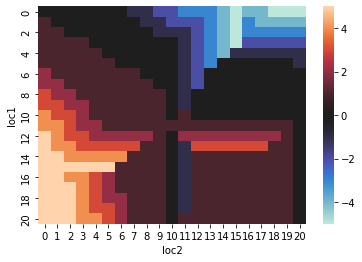

In [6]:
from numpy.testing import assert_almost_equal
import pandas as pd
import seaborn as sns
from dp import StateValueFunction
from dp.jackscarrental import JacksCarRental
from dp.solve import policy_iteration

class ModifiedJCR(JacksCarRental):
    """Modified version of Jack's car rental problem, as described in Exercise
    4.7 of the textbook."""
    def __init__(self):
        # Initialise base class with problem parameters given in the textbook
        super().__init__(
            capacity=20,
            overnight_moves_limit=5,
            exp_demand_per_location=(3, 4),
            exp_returns_per_location=(3, 2),
            reward_for_rental=10.0,
            reward_per_car_for_moving_cars=-2.0,
        )
        
    def exp_reward(self, action, exp_rentals, next_morning_counts):
        # Modified reward function as described in the question text
        if action > 0:
            action_reward = self.reward_per_car_for_moving_cars * (action - 1)
        else:
            action_reward = - self.reward_per_car_for_moving_cars * action
        storage_reward = -4.0 * ((next_morning_counts[0] > 10) + (next_morning_counts[1] > 10))
        rental_reward = exp_rentals * self.reward_for_rental
        return action_reward + storage_reward + rental_reward
    
# Unit tests to check whether reward is calculated correctly
mod_jcr = ModifiedJCR()
assert_almost_equal(mod_jcr.exp_reward(3, 5, (7, 13)), -2.0 * (3 - 1)  - 4.0 + 5 * 10.0)
assert_almost_equal(mod_jcr.exp_reward(-2, 5, (15, 2)), -2.0 * 2 - 4.0 + 5 * 10.0)
assert_almost_equal(mod_jcr.exp_reward(1, 5, (15, 16)), -8.0 + 5 * 10.0)

# Solve using policy iteration
v = StateValueFunction(mod_jcr)
pi = {s: mod_jcr.actions(s)[0] for s in mod_jcr.states}  # arbitrary initial policy
policy_iteration(v, pi, gamma=0.9, tol=0.1)

# Convert optimal policy to a matrix (dataframe) and visualise
pi_df = pd.Series(
    pi.values(),
    index=pd.MultiIndex.from_tuples(pi.keys(), names=["loc1", "loc2"]),
    name="action",
).unstack()
sns.heatmap(pi_df, cmap="icefire")

Some observations (sense checks) on the optimal policy for this modified version of the problem:
* Because it is now free to move one car from location 1 to location 2, the optimal policy for the modified problem often does so (considering that location 2 has a mismatch between supply and demand)
* There are cliff-edge effects where either location 1 or two crosses threshold of having 10 cars. This make sense due to the new charge to use a second parking lot for any additional cars at each location: where the number of cars exceeds 10 slightly in one location but not the other, it may make sense to move cars to avoid this charge. Note that when locations have well in excess of 10 cars, it no longer makes sense to worry about this, because the cost of moving cars will exceed the (fixed) charge for using a second parking lot.

### Exercise 4.8

Q: Why does the optimal policy for the gambler's problem have such a curious form? In particular, for capital of 50 it bets it all on one flip, but for capital of 51 it does not. Why is this a good policy?

A: Let's begin by reproducing the optimal policy for $p_h = 0.4$ (as illustrated in Figure 4.3 in the book):

  1%|▍                                        | 10/1000 [00:00<00:11, 82.77it/s]


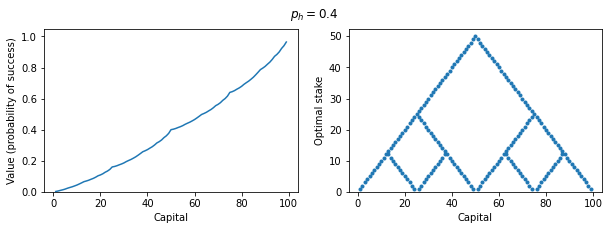

In [7]:
import matplotlib.pyplot as plt
from dp import StateValueFunction
from dp.solve import value_iteration
from dp.gamblersproblem import GamblersProblem

def solve_and_visualise_gamblers_problem(
    goal: int, p_h: int, gamma: float = 1.0,
) -> plt.Figure:
    # Set up and solve problem
    gp = GamblersProblem(goal=goal, p_h=p_h)
    v = StateValueFunction(gp)
    value_iteration(v, gamma=gamma, tol=0.00001, maxiter=1000)

    # Display state-values and optimal actions
    f, (axl, axr) = plt.subplots(1, 2, figsize=(10, 3))
    v_pairs = [
        (capital, value)
        for capital, value in v.to_dict().items()
        if capital not in {0, 100}
    ]
    axl.plot(*zip(*v_pairs))
    axl.set_ylim([0.0, 1.05])
    axl.set_xlabel("Capital")
    axl.set_ylabel("Value (probability of success)")
    optimal_actions = v.optimal_actions_map(gamma=gamma)
    capital_stake_pairs = [
        (capital, stake)
        for capital, stakes in optimal_actions.items() for stake in stakes
        if capital not in {0, 100}
    ]
    axr.plot(
        *zip(*capital_stake_pairs),
        ".",
    )
    axr.set_ylim([0, None])
    axr.set_xlabel("Capital")
    axr.set_ylabel("Optimal stake")
    f.suptitle(f"$p_h={p_h}$")
    return v, f
    
solve_and_visualise_gamblers_problem(goal=100, p_h=0.4);

Notice that the optimal policy chart doesn't look quite like the one in the book. That is because we've plotted, for every state, *all* the optimal actions available to the agent. Nevertheless, the optimal policy shown in the book is clearly consistent with this plot of all optimal actions in each state.

Why does the optimal policy take this form?

Recall that this is an undiscounted problem, hence the agent doesn't care how long it takes to reach the goal state, the only priority is get to the goal (100) without first hitting the other terminal state of losing all one's capital. Nevertheless, we would expect some continuity with the optimal policy for a discounted problem: in particular if $gamma = 1 - \epsilon$ for a very small $epsilon$, we would not expect the gambler's optimal behaviour to change. Why does this matter? Because, even if we set $gamma$ just marginally below 1, we see that it is never optimal for the gambler to do nothing, i.e. to bet a stake of zero, as that is just delaying the time it takes to get to the terminal states, reducing the return. In the limit $\gamma \to 1$, this argument no longer strictly holds, as the gambler could in principle do nothing forever and the episode would never terminate; however we would expect for any state that there would still be at least one optimal action that involves placing a non-zero bet (as we see borne out in the charts above).

Next, we note that with $p_h = 0.4$, the gambler is more likely to lose any given bet than to win it. So (neglecting zero-bets for the reasons above), the gambler needs to set stakes to try and reach the target in as few bets as possible (because a trajectory involving more bets is more likely to go wrong). This means that the gambler is incentivised to be quite aggressive in the stakes they set.

These points in turn explains the shape of the state-value function (lefthand chart) and the optimal policies:
* The state-value function is made up of many convex sections.
* Within each convex section, it is optimal to make a bet, and the best stake is one that could take the gambler to an edge of a convex section. For example, between 13 and 24, the gambler would set a stake that could potentially get them to either 25 or 50. The gambler is happy to bet big to achieve this for the reasons given above.
* The edges of the convex sections correspond to divisions of 100 by powers of two. The first two are clearcut (because 100 is a multiple of 4) whereas beyond that the edges get softened due to the problem only allowing integer stakes.
* At the edges, both the graphs show that (for an exactly undiscounted problem), the gambler is indifferent between a zero-stake and a stake that would take them to the next best edge (e.g. at 75, the gambler could stake 0 or stake 25 to get them to 50 or 100).

### Exercise 4.9

Q: Implement value iteration for the gambler's problem and solve it for $p_h = 0.25$ and $p_h = 0.55$. (...) Show your results graphically, as in Figure 4.3. Are your results stable as $\theta \to 0$?

A: There appears to be a typo in this question, as it is not clear what $\theta$ is meant to be. But let's answer the first part of the question by solving the gambler's problem for these two values of $p_h$:

 76%|█████████████████████████████▌         | 758/1000 [00:07<00:02, 104.23it/s]


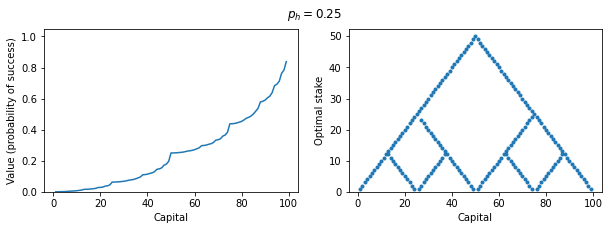

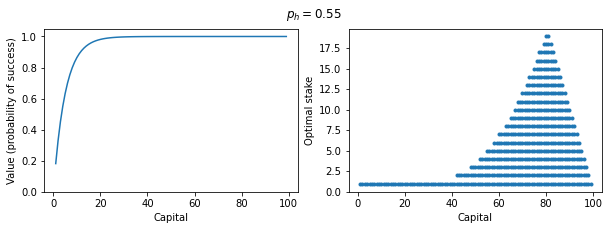

In [8]:
solve_and_visualise_gamblers_problem(goal=100, p_h=0.25);
solve_and_visualise_gamblers_problem(goal=100, p_h=0.55);

Notice that the solution for $p_h = 0.25$ is similar to the solution for $p_h = 0.4$. The optimal actions are the same and the shape of the state-value function is similar. This makes sense because the explanation given above for the $p_h = 0.4$ problem applies equally to the $p_h = 0.25$ with the only difference being that the gambler is even more likely to lose than win at each bet (making the kinks in the state-value function even more pronounced).

On the other hand, the solution for $p_h = 0.55$ is very different. Now, the gambler is (slightly) more likely to win a bet than to lose one. Hence, with $\gamma = 1$, it makes sense to bet conservatively and slowly build up capital, to minimise the risk of losing it all. Hence we see that a stake of 1 is optimal whatever position the gambler is in. As the gambler accumulates a good amount of capital and therefore has a decent safety cushion, there is also the option of staking more than 1 at each turn — although, with no discounting of future rewards, there is no reason to do so (the expected return remains the same as the more cautious approach of staking 1).

### Question 4.10

Q: What is the analog of the value iteration update for action values, $q_{k+1}(s, a)$?

A: Recall that the value iteration update for state values is:

$$v_{k+1}(s) \doteq \max_{a \in \mathcal{A(s)}} \sum_{s' \in \mathcal{S}} p(s'|s,a) \left[r(s,a,s') + \gamma \, v_k(s')\right].$$

Its fixed point satisfies the Bellman optimality equation for state-value functions and is therefore the state-value function for an optimal policy.

Analogously, the value iteration update for action values is as follows:

$$q_{k+1}(s, a) \doteq \sum_{s' \in \mathcal{S}} p(s'|s,a) \left[r(s,a,s') + \gamma \max_{a' \in \mathcal{A}(s')} q_k(s', a')\right].$$